In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import Models.OWID as owid
import Models.SIRD as sird
import Models.GradientDescent as gd

import scipy.optimize as opt

#parameters are [A(0), I(0), gamma0, gamma1, nu, beta0, beta1, beta2, u(t) vars]
#consts are [dayNum, I[0], maxI, len(u(t))]

#A' = (b0 / (1 + (b1 * I)**(b2 * u(t)) ) )*A - gamma0*A
#I' = gamma1*A - nu*I


def startFunc(consts):
    
    #return ukVars
    params = np.zeros(8)
        
    params[0] = .001 + consts[1] #A(0), between 0 and 10 percent of the population
    params[1] = consts[1] #10e-10 + random.random()*.01 #I(0), between 0 and .1 percent of the population, avoid 0
    
    params[2] = .1 + random.random()*.4 #gamma0, asympt->recovs + infected - floor asympt infect rate
    params[3] = .001 + random.random()*.1 #gamma1, asympt->infected
    
    params[4] = .001 + random.random()*.1 #nu, infected -> recov or dead

    params[5] = .3 + random.random()*1.5 #beta0, ceiling infectRate - floor infect rate
    params[6] = 13 + 125*random.random() #beta2, scaler on feedback
    params[7] = .5 + random.random()*2 #beta3, exponential [.5, 5.5]
    
    #beta1 = (b0/gamma0 - 1)**(1/u(t)*b2) / maxI
    #params[6] = ((params[5]/params[2])-1)**(1/(params[7])) / consts[2]
    
    
    return params
    
def simFunc(params, consts, giveA=False): #option to return A and I

    dayNum = consts[0]
    
    A = np.zeros((dayNum))
    I = np.zeros((dayNum))
    
    A[0] = params[0]
    I[0] = params[1]
    
    gamma0 = params[2]
    gamma1 = params[3]
    nu = params[4]
    
    beta = params[5:8]

    #print(params)
    
    #iterate the arrays using the definition K' and I'
    for t in range(len(I)-1): #define I and K on range [1, length)
        diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]
        diffI = gamma1*A[t] - nu*I[t]
        
        A[t+1] = diffA + A[t]
        I[t+1] = diffI + I[t]

    if(giveA):
        return A,I
        
    return I #I is the data generated

def constrainFunc(parameters, consts):
    
    params = np.copy(parameters)

    #fill the constraints
    paramConstraints = np.zeros((len(params),2)) #min, max for each one
    
    paramConstraints[0] = [.0000000001, .5] #A(0)
    paramConstraints[1] = [ 0.000000001, .25] #I(0)

    paramConstraints[2] = [0.00001, parameters[5]] #gamma0, has to be less than ceiling infection rate
    paramConstraints[3] = [0.00001, .9] #gamma1
    
    paramConstraints[4] = [0.00001, .9] #nu

    paramConstraints[5] = [.1, 100] #beta0, beta ceiling
    paramConstraints[6] = [.1, 100000] #beta1, feedback scaling
    paramConstraints[7] = [.25, 10] #beta2
    
    for i in range(len(params)): #exercise each constraint
        params[i] = min( max(paramConstraints[i,0], params[i]) , paramConstraints[i,1])
    
    return params

def graphParams(params, consts, graphA=False):
    A, I = simFunc(params, consts, giveA=True)
    
    fig, ax = plt.subplots(figsize=(18,8))
    if(graphA):
        ax.plot(A, color="orange", linestyle="dashed", alpha=.7)
    ax.plot(I, color="red")
    return fig, ax




#x is the starting params, args = (consts, y)
def errFunc(x, consts, normalWeight, slopeWeight, wDecay, skip, y):
    
    def simFunction(params, consts, giveA=False): #option to return A and I

        dayNum = consts[0]

        A = np.zeros((dayNum))
        I = np.zeros((dayNum))

        A[0] = params[0]
        I[0] = params[1]

        gamma0 = params[2]
        gamma1 = params[3]
        nu = params[4]

        beta = params[5:8]

        #print(params)

        #iterate the arrays using the definition K' and I'
        for t in range(len(I)-1): #define I and K on range [1, length)
            diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]
            diffI = gamma1*A[t] - nu*I[t]

            A[t+1] = diffA + A[t]
            I[t+1] = diffI + I[t]

        if(giveA):
            return A,I

        return I #I is the data generated

    x = simFunction(x, consts)
    
    error = 0
    if(normalWeight!=0):
        for t in range(skip,len(y)):
            error = error + ((y[t] - x[t])**2)*wDecay**(len(y)-t+1) #squared error
        error = error / len(y) # / T, average error
    
    
    slopeError = 0
    if(slopeWeight!=0):
        dy = np.diff(y)
        dx = np.diff(x)
        for t in range(skip,len(dy)):
            slopeError = slopeError +  ((dy[t] - dx[t])**2)*wDecay**(len(dy)-t+1) #squared error
        slopeError = slopeError / len(dy) # / T, average error

    return error*normalWeight + slopeError*slopeWeight



def getParams(I, consts, normalWeight=1, slopeWeight=0, wDecay=1, skip=0, randomIterCount=100, method="SLSQP"):
    bestParams = startFunc(consts)
    bestError = 10e10 #arbitrary large value
    
    for i in range(randomIterCount):
        
        newParams = startFunc(consts)
        newParams = opt.minimize(errFunc, newParams, (consts, normalWeight, slopeWeight, wDecay, skip, I), method=method)['x']
        newError = errFunc(newParams, consts, normalWeight, slopeWeight, wDecay, skip, I)
    
        if(newError < bestError):
            bestError = newError
            bestParams = newParams
            print(i, "New best error: ", bestError)
            
    return bestParams

def getStablePoint(params, consts):
    #I stable point = (b0/gamm0 - 1)^(1/b2) / b1
    #A stable point = nu/gamma1 * (b0/gamm0 - 1)^(1/b2) / b1
    
    gamma0 = params[2]
    gamma1 = params[3]
    nu = params[4]
    beta = params[5:]
    
    return (beta[0]/gamma0 - 1)**(1/beta[2]) / beta[1]

In [2]:
randomIterCount = 100
quickRunIters = 25 #how many iterations on the first convergance
lastRunIters = 500
beginEta = .01 #large learnin rate for quick converging
finalEta = .01

slopeWeight = 1

## Italy

<ipython-input-84-6a3f38c511c6>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  1.983976070268913e-05
3 New best error:  1.629003891877367e-05
4 New best error:  1.6285392900776117e-05
53 New best error:  1.5089456433966014e-05
70 New best error:  1.3800943956034706e-05
[7.70175728e-03 3.52063914e-04 3.24145965e-01 3.20152379e-01
 2.41353405e-02 3.63975055e-01 5.23141051e+01 1.92287654e+00]


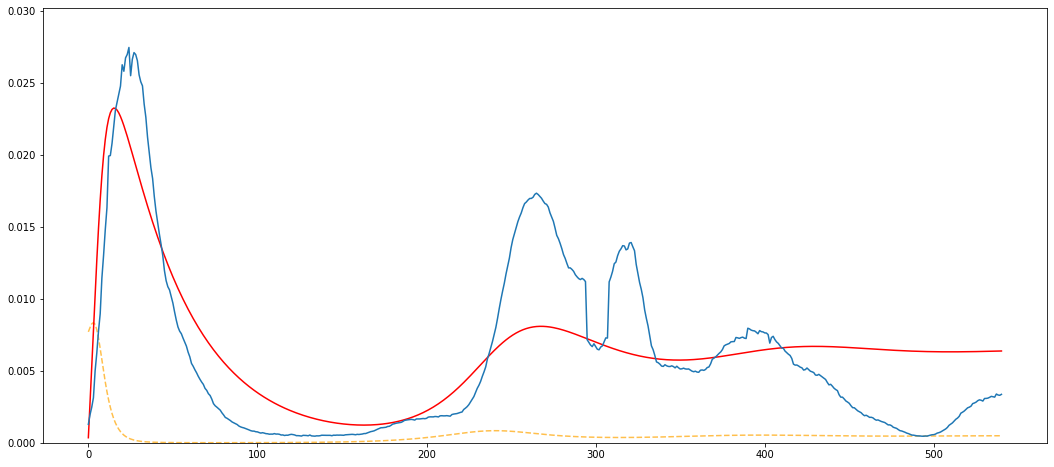

In [85]:
dates, I, R, D, V = owid.LoadCountryNormal("Italy")
consts = [len(I), I[0], max(I), 0]

italyParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")


fig,ax = graphParams(italyParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

print(italyParams)

## US

<ipython-input-84-6a3f38c511c6>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  6.925499138191984e-06
1 New best error:  6.080639338274261e-06
3 New best error:  5.845471844548533e-06
24 New best error:  5.8410799866436806e-06
26 New best error:  5.805113919612488e-06
38 New best error:  3.4667789683608538e-06


(0.0, 0.018441267693175955)

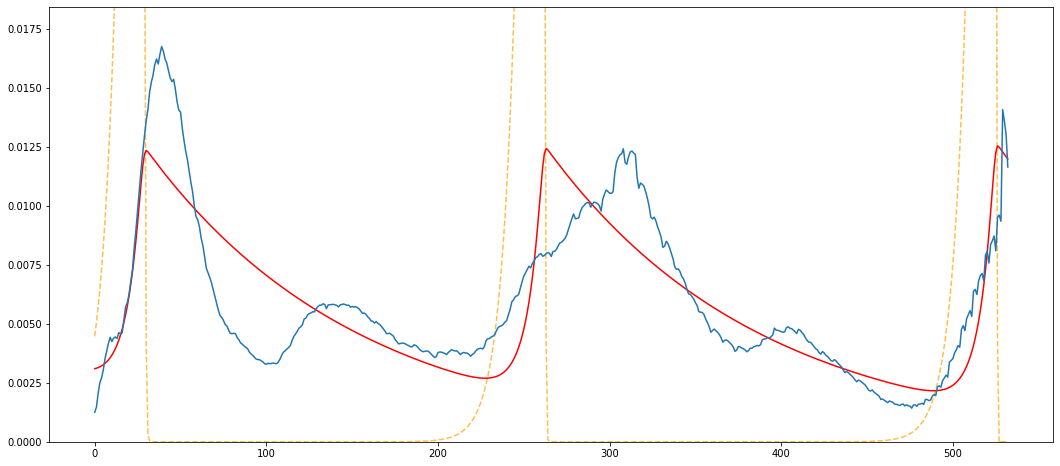

In [86]:
dates, I, R, D, V = owid.LoadCountryNormal("United States")
consts = [len(I), I[0], max(I), 0]

usParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(usParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## UK

<ipython-input-84-6a3f38c511c6>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  1.9580925045047105e-05
7 New best error:  1.6745204860020698e-05
9 New best error:  1.4773657513329569e-05
21 New best error:  1.3511781407435582e-05
28 New best error:  1.330494993395692e-05


<ipython-input-84-6a3f38c511c6>:131: RuntimeWarning: overflow encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


41 New best error:  1.218220177118754e-05


(0.0, 0.04658249629830908)

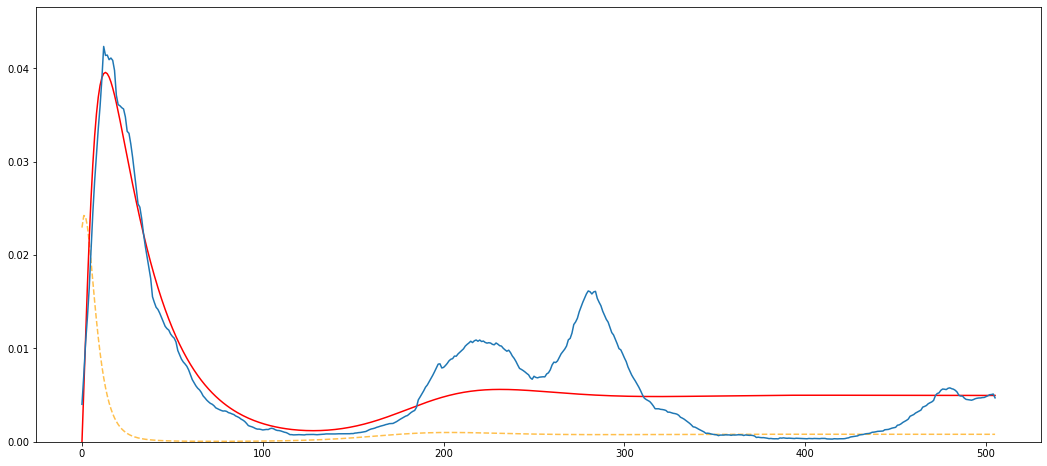

In [87]:
dates, I, R, D, V = owid.LoadCountryNormal("United Kingdom")
consts = [len(I), I[0], max(I), 0]

ukParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(ukParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Canada

0 New best error:  9.197837284979115e-06


<ipython-input-84-6a3f38c511c6>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


1 New best error:  7.589209407183045e-06
9 New best error:  7.545428992303023e-06
32 New best error:  7.415713621602136e-06
73 New best error:  7.410097985464217e-06


(0.0, 0.02405621083757516)

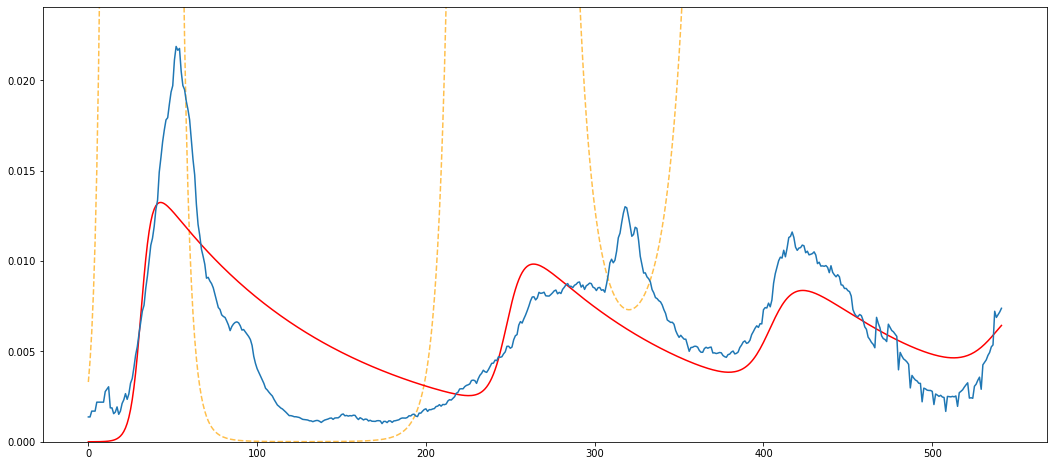

In [88]:
dates, I, R, D, V = owid.LoadCountryNormal("Canada")
consts = [len(I), I[0], max(I), 0]

canadaParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(canadaParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Mexico

<ipython-input-84-6a3f38c511c6>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  1.2566367399330728e-06
1 New best error:  1.226555620168404e-06
2 New best error:  1.1308111368373588e-06
8 New best error:  1.1091323265151932e-06


(0.0, 0.010837001598060553)

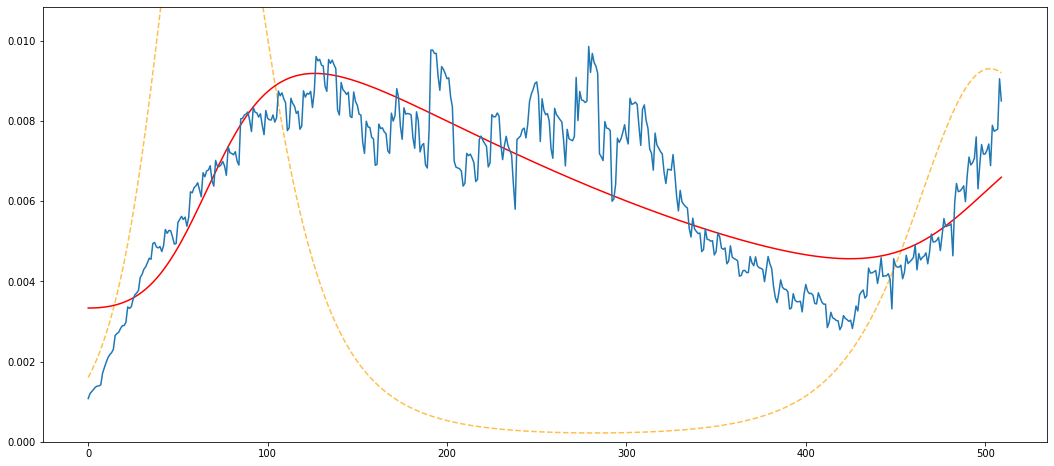

In [89]:
dates, I, R, D, V = owid.LoadCountryNormal("Mexico")
consts = [len(I), I[0], max(I), 0]

mexicoParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(mexicoParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Israel

<ipython-input-84-6a3f38c511c6>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  2.1839711881965447e-05
6 New best error:  2.1507365457204815e-05
9 New best error:  1.954570718878043e-05
10 New best error:  1.951810706236965e-05
16 New best error:  1.6695130483104395e-05
30 New best error:  1.5557631169054945e-05


(0.0, 0.020971920205352997)

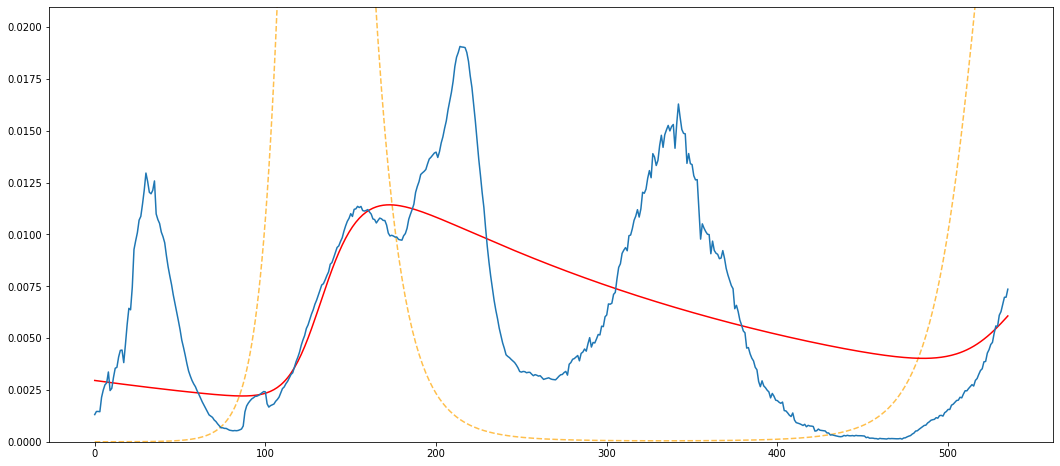

In [90]:
dates, I, R, D, V = owid.LoadCountryNormal("Israel")
consts = [len(I), I[0], max(I), 0]

israelParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(israelParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Russia

0 New best error:  6.6543448053483175e-06
3 New best error:  6.53954592015547e-06


<ipython-input-84-6a3f38c511c6>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


8 New best error:  6.464942080236156e-06
12 New best error:  6.271664528754671e-06


(0.0, 0.015384002666381675)

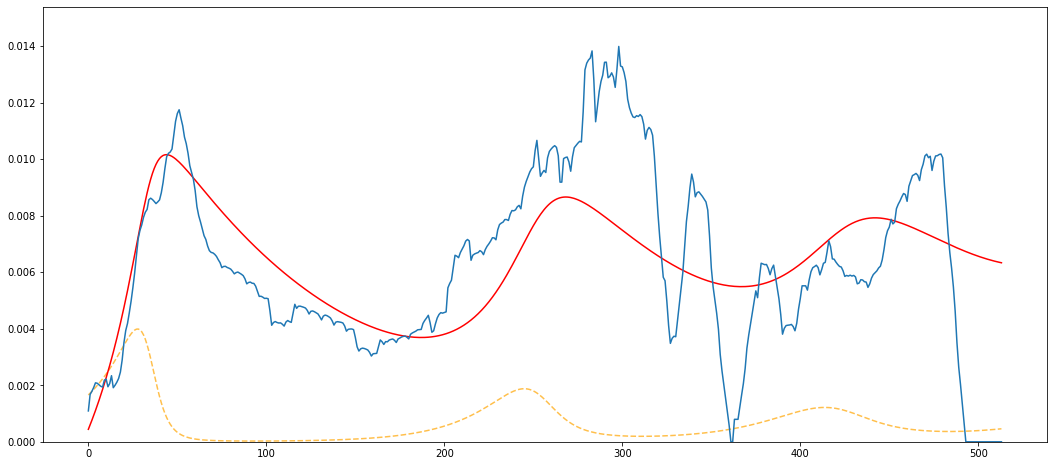

In [91]:
dates, I, R, D, V = owid.LoadCountryNormal("Russia")
consts = [len(I), I[0], max(I), 0]

russiaParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(russiaParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## South Africa

<ipython-input-84-6a3f38c511c6>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  9.225838623636818e-06
2 New best error:  8.815055249946102e-06
10 New best error:  8.627546231446031e-06
76 New best error:  8.558139123395923e-06


(0.0, 0.01813797736939064)

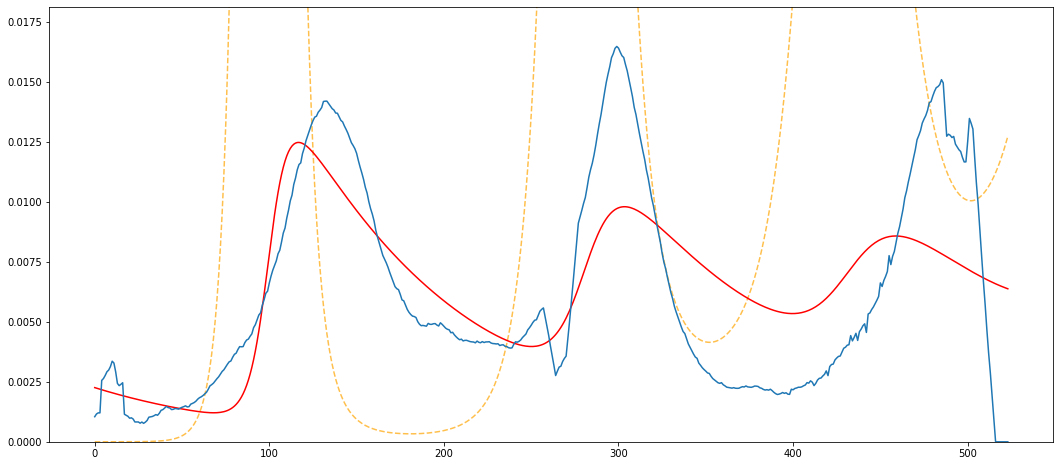

In [92]:
dates, I, R, D, V = owid.LoadCountryNormal("South Africa")
consts = [len(I), I[0], max(I), 0]

southAfricaParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(southAfricaParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Australia

<ipython-input-84-6a3f38c511c6>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


0 New best error:  8.726565681000965e-05
3 New best error:  6.788424893408381e-05
34 New best error:  6.181344901927018e-05


<ipython-input-84-6a3f38c511c6>:147: RuntimeWarning: overflow encountered in double_scalars
  error = error + ((y[t] - x[t])**2)*wDecay**(len(y)-t+1) #squared error


(0.0, 0.06187422274640893)

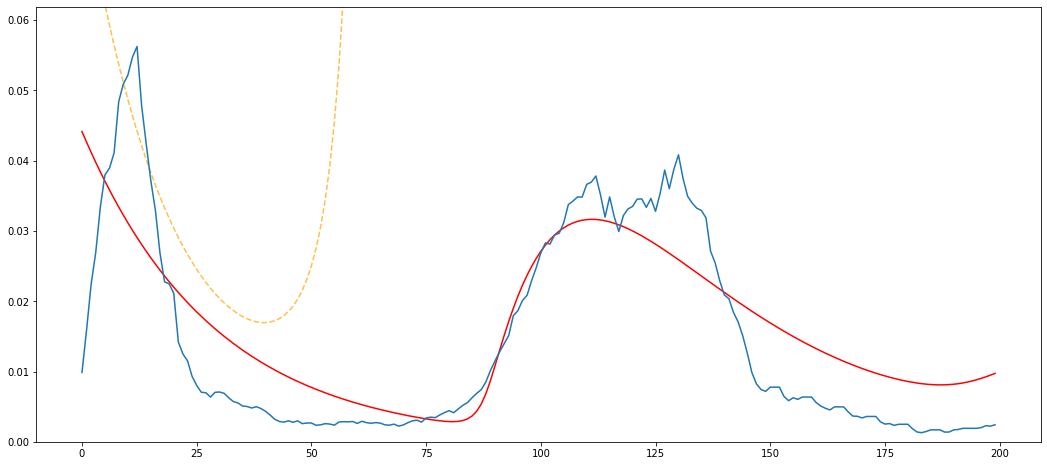

In [93]:
dates, I, R, D, V = owid.LoadCountryNormal("Australia")
dates = dates[0:200]
I = I[0:200]
consts = [len(I), I[0], max(I), 0]

auParams = getParams(I, consts, randomIterCount=100, method = "Nelder-Mead")

fig,ax = graphParams(auParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Turkey

0 New best error:  2.7015933102820893e-05


<ipython-input-84-6a3f38c511c6>:131: RuntimeWarning: invalid value encountered in double_scalars
  diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]


1 New best error:  1.9043030250452358e-05
2 New best error:  1.739042980460253e-05
18 New best error:  1.681666666396388e-05


(0.0, 0.0291976837360973)

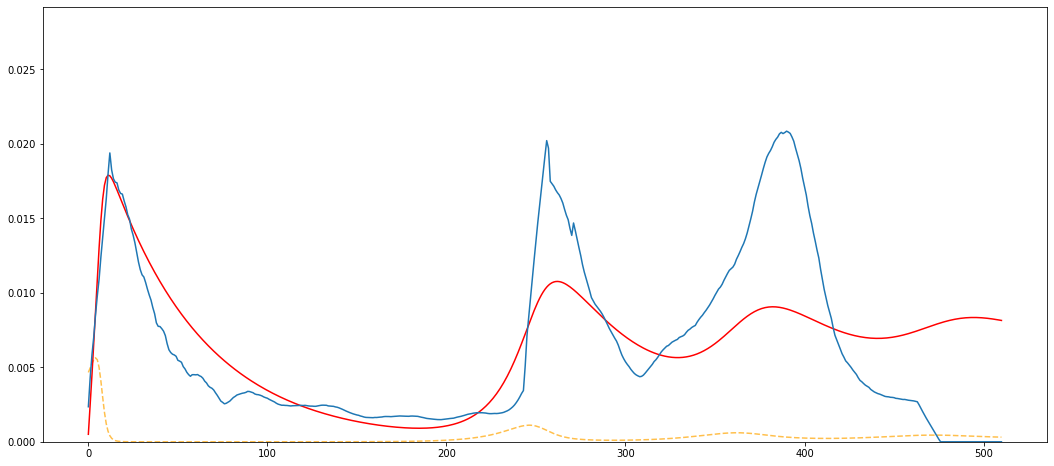

In [94]:
dates, I, R, D, V = owid.LoadCountryNormal("Turkey")

consts = [len(I), I[0], max(I), 0]

turkeyParams = getParams(I, consts, randomIterCount=100, wDecay=(.75**(1/len(I))), method = "Nelder-Mead")

fig,ax = graphParams(turkeyParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.4])

In [95]:
import csv


outputFile = open('..\\Data\\AIRD fits\\fits2.csv', 'w')
writer = csv.writer(outputFile)


row = italyParams.tolist()
row.insert(0, "Italy")
writer.writerow(row)

row = usParams.tolist()
row.insert(0, "United States")
writer.writerow(row)

row = ukParams.tolist()
row.insert(0, "United Kingdom")
writer.writerow(row)

row = canadaParams.tolist()
row.insert(0, "Canada")
writer.writerow(row)

row = mexicoParams.tolist()
row.insert(0, "Mexico")
writer.writerow(row)

row = israelParams.tolist()
row.insert(0, "Israel")
writer.writerow(row)

row = russiaParams.tolist()
row.insert(0, "Russia")
writer.writerow(row)

row = southAfricaParams.tolist()
row.insert(0, "South Africa")
writer.writerow(row)

row = auParams.tolist()
row.insert(0, "Australia")
writer.writerow(row)

row = turkeyParams.tolist()
row.insert(0, "turkey")
writer.writerow(row)

outputFile.close()

normal-death error:  7.499631978033246e-05
mod-death error:  0.00013316714788320924
mod/normal error: 1.7756491021594354


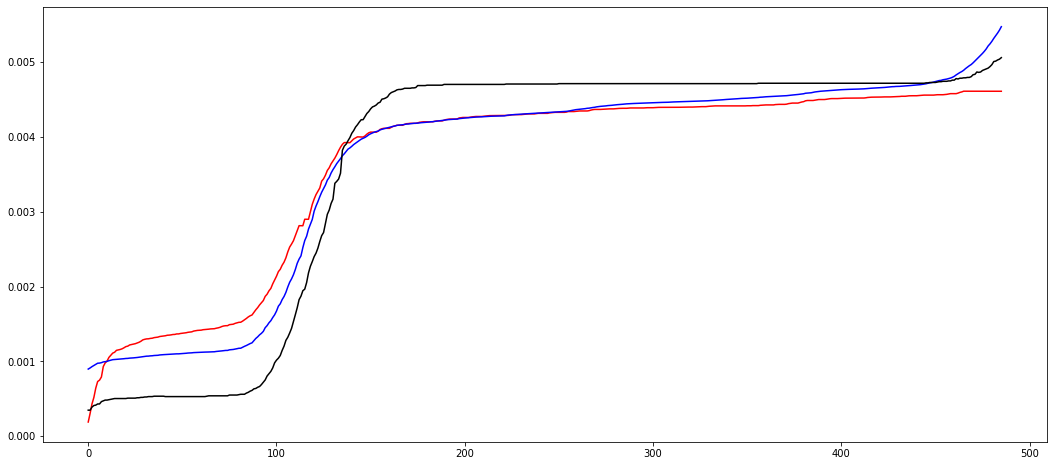

In [92]:
countryName = "Australia"

dates, I, R, D, V = owid.LoadCountryNormal(countryName)

dates2, [actualI, pop] = owid.LoadCountry(countryName, [4, 46])

startDate = np.where(dates2 == dates[0])[0][0]
endDate = np.where(dates2 == dates[-1])[0][0]

dates2 = dates2[startDate:endDate+1]
actualI = actualI[startDate:endDate+1]
pop = pop[0]

actualI = actualI/pop #transform so max pop is 1

shiftAmount = 15
deadShift = D[shiftAmount:]
modIShift = I[0:-shiftAmount] + R[0:-shiftAmount]
actualIShift = actualI[0:-shiftAmount]

fig,ax = plt.subplots(figsize=(18,8))

deathScale = (sum(modIShift)/len(modIShift)) / (sum(deadShift)/len(deadShift))
infectScale = (sum(modIShift)/len(modIShift)) / (sum(actualIShift)/len(actualIShift))

ax.plot(modIShift, color="red")
ax.plot(infectScale*actualIShift, color="blue")
ax.plot(deathScale*deadShift, color="black")

normalError = sum(((infectScale*actualIShift)-(deathScale*deadShift))**2)
modError = sum(((modIShift)-(deathScale*deadShift))**2)
print("normal-death error: ", normalError)
print("mod-death error: ", modError)
print("mod/normal error:", modError/normalError)

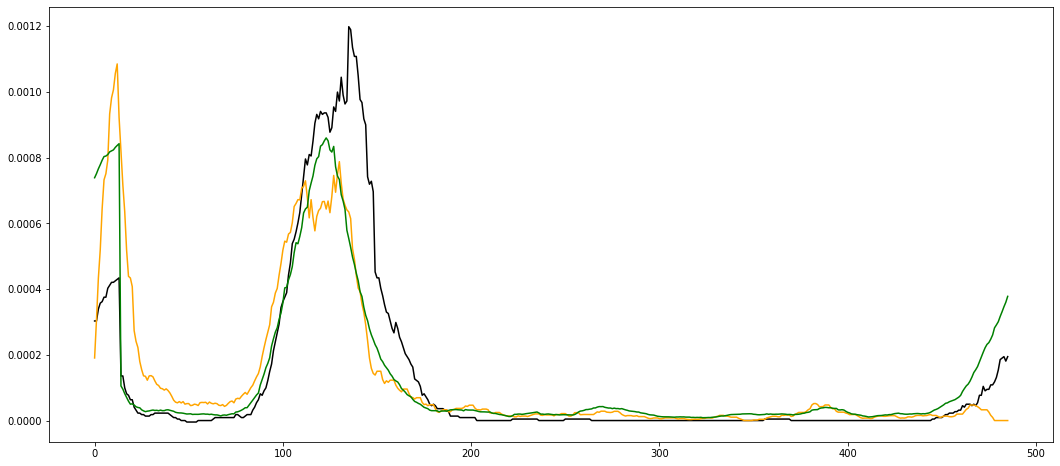

In [93]:
fig, ax = plt.subplots(figsize=(18,8))

recov = np.zeros(len(deadShift)) #R+D
shift = 14
for i in range(len(deadShift) - shift):
        recov[i + shift] = deadShift[i]

reportedI = actualIShift
recov2 = np.zeros(len(deadShift)) #R+D
for i in range(len(reportedI) - shift):
        recov2[i + shift] = reportedI[i]

reportedI = reportedI - recov2
currInfect = deadShift - recov
modIShift = I[0:-shiftAmount]

currInfect = currInfect * (sum(modIShift)/len(modIShift)) / (sum(currInfect)/len(currInfect))
reportedI = reportedI * (sum(modIShift)/len(modIShift)) / (sum(reportedI)/len(reportedI))

ax.plot(currInfect, color="black") #approx from dead
ax.plot(modIShift, color="orange") #approx from tests
ax.plot(reportedI, color="green") #reported

<ipython-input-83-1d4c2a5be5ad>:5: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(newCases/newTests, color="red") #percent of positive tests
<ipython-input-83-1d4c2a5be5ad>:5: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(newCases/newTests, color="red") #percent of positive tests


(0.0, 1.05)

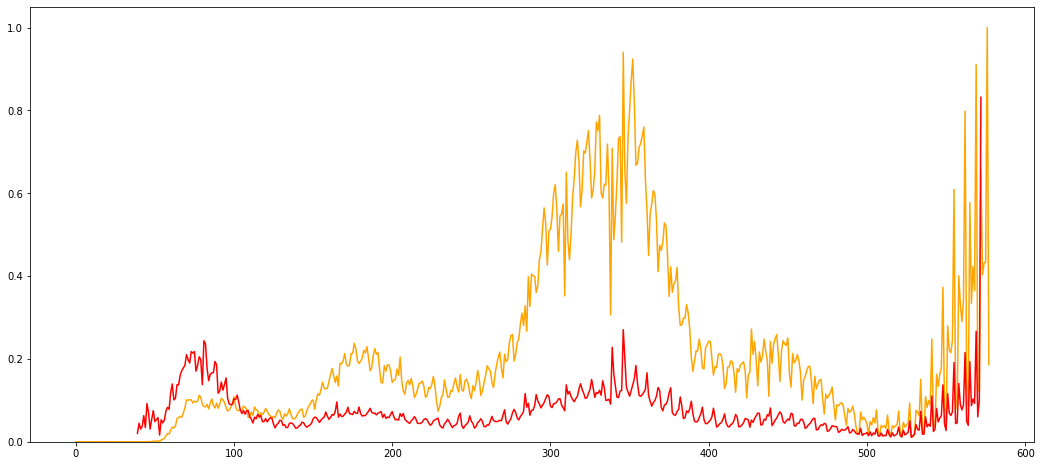

In [83]:
dates3, [newCases, newTests] = owid.LoadCountry("United States", [5, 25])

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(newCases/max(newCases), color="orange") #scaling is arbitrary
ax.plot(newCases/newTests, color="red") #percent of positive tests
ax.set_ylim(0)

In [5]:
def getIndex(A, item):
    index = 0
    while(index < len(A) and A[index] != item):
        index = index + 1
    
    if(index == len(A)):
        return -1 #doesn't exists
    return index #found

import csv
import platform
def getCountryDates(countryName):
    fileName = "../Data/Country Policy Data/" #mac file address
    #pathc="../Data/Covid Tracking State Data/"
    if platform.system() == "Windows":
        fileName.replace("/", "\\")
    fileName = fileName+countryName + ".csv"
    
    csvFile = open(fileName, newline='', encoding='UTF-8')
    rd = csv.reader(csvFile, delimiter=',') #reader
    data=[] #the data of all countries
    for lv in rd: #generating the data matrix
        data.append(lv)

    labels = np.array(data[0]) #get the labels
    data = data[1:] #remove the header
    data = np.array(data) #convert to np array for simplicity
    
    return data[:,0].transpose() #just the dates

## Regions of constant period (for Italy, United Kingdom, Australia)

# Italy

[0.007701757277441129, 0.00035206391425336904, 0.32414596532803197, 0.32015237917397077, 0.024135340525104913, 0.36397505470220093, 52.31410513728453, 1.9228765430482753]


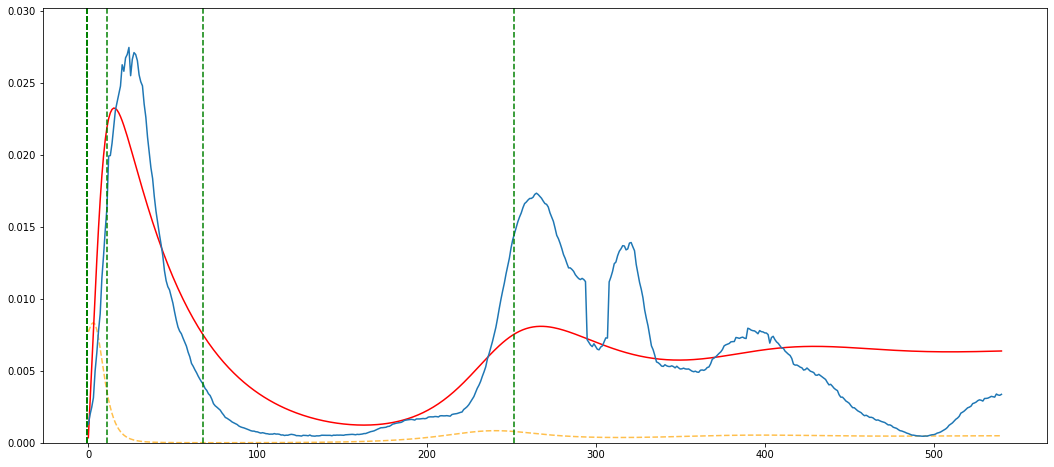

In [16]:
dates, I, R, D, V = owid.LoadCountryNormal("Italy")
consts = [len(I), I[0], max(I), 0]

#italyParams = getParams(I, consts, randomIterCount=10, method = "Nelder-Mead")
italyParams = [0.007701757277441129,0.00035206391425336904,0.32414596532803197,0.32015237917397077,0.024135340525104913,
               0.36397505470220093,52.31410513728453,1.9228765430482753]

fig,ax = graphParams(italyParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

print(italyParams)

measureDates = getCountryDates("Italy")

for measure in measureDates:
    plt.axvline(x=getIndex(dates, measure), color="green", linestyle='--')

0 New best error:  3.179251791324228e-06
3 New best error:  2.172621868574116e-06


C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars


(0.0, 0.030195573779575175)

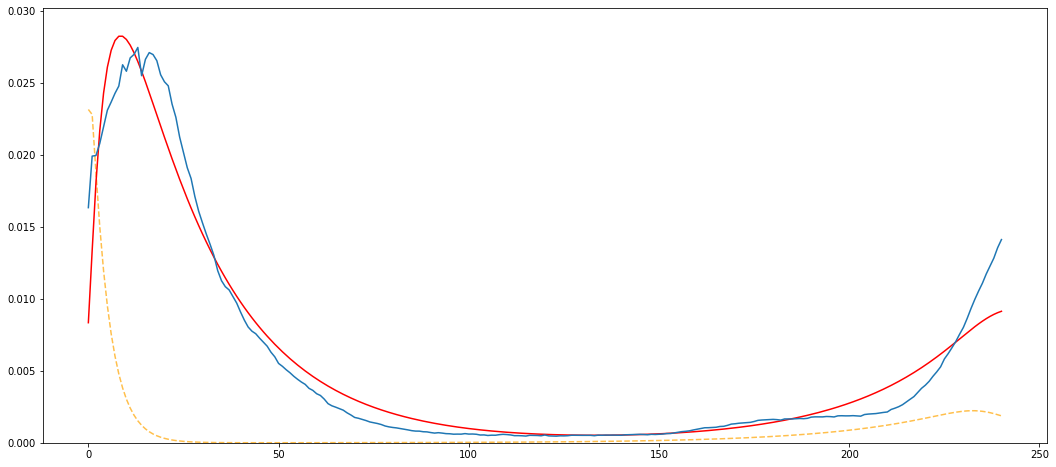

In [44]:
measureDates = getCountryDates("Italy")
    
dates, I, R, D, V = owid.LoadCountryNormal("Italy")

startDate = getIndex(dates, measureDates[0])
endDate = getIndex(dates, measureDates[2])

dates = dates[startDate:endDate]
I = I[startDate:endDate]

consts = [len(I), I[0], max(I), 0]

italyParamsLate = getParams(I, consts, randomIterCount=5, method = "Nelder-Mead")

fig,ax = graphParams(italyParamsLate, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

# United Kingdom

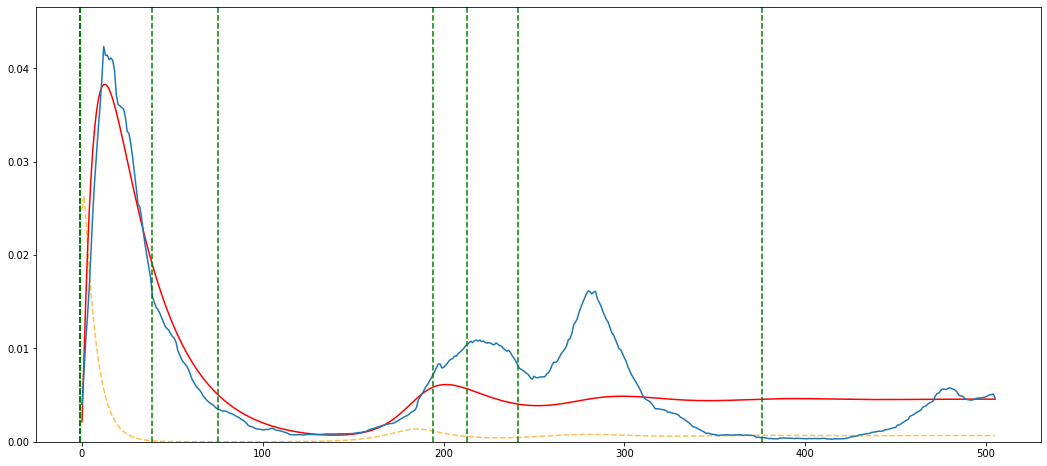

In [26]:
dates, I, R, D, V = owid.LoadCountryNormal("United Kingdom")
consts = [len(I), I[0], max(I), 0]

#ukParams = getParams(I, consts, randomIterCount=25, method = "Nelder-Mead")

fig,ax = graphParams(ukParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

measureDates = getCountryDates("United Kingdom")

for measure in measureDates:
    plt.axvline(x=getIndex(dates, measure), color="green", linestyle='--')

0 New best error:  6.955907819347004e-06
3 New best error:  6.5928254005518585e-06


C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars


(0.0, 0.017774713924476417)

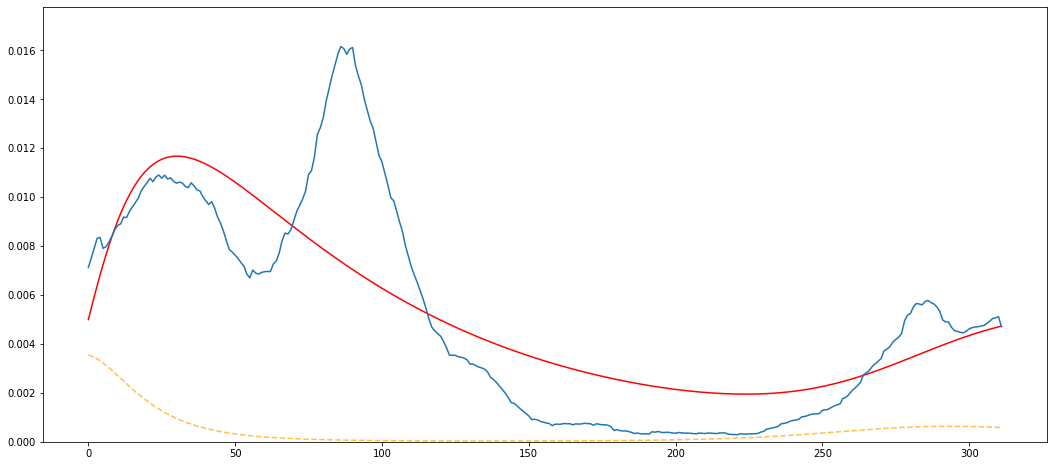

In [38]:
measureDates = getCountryDates("United Kingdom")
    
dates, I, R, D, V = owid.LoadCountryNormal("United Kingdom")

startDate = getIndex(dates, measureDates[-4])

dates = dates[startDate:]
I = I[startDate:]

consts = [len(I), I[0], max(I), 0]

ukParamsLate = getParams(I, consts, randomIterCount=5, method = "Nelder-Mead")

fig,ax = graphParams(ukParamsLate, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

# Australia

[1.08328970e-05 2.03680779e-02 8.89803072e-02 3.77751393e-10
 3.67327150e-02 3.50363788e+00 9.85064700e+02 4.88942870e+00]


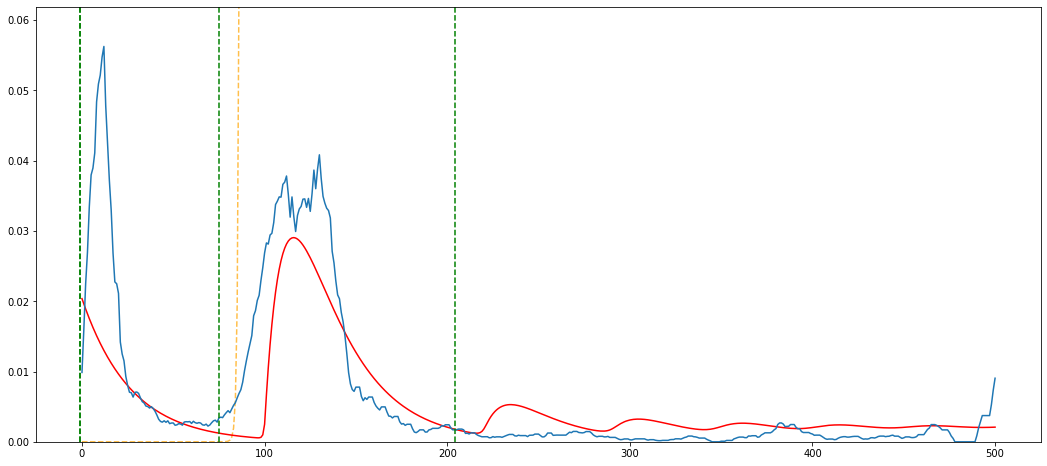

In [21]:
dates, I, R, D, V = owid.LoadCountryNormal("Australia")
consts = [len(I), I[0], max(I), 0]

auParams = getParams(I, consts, randomIterCount=10, method = "Nelder-Mead")


fig,ax = graphParams(auParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

print(auParams)

measureDates = getCountryDates("Australia")

for measure in measureDates:
    plt.axvline(x=getIndex(dates, measure), color="green", linestyle='--')

C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars


0 New best error:  3.8517570679107585e-05
4 New best error:  2.362125418689685e-05
7 New best error:  1.9324046441045054e-05


(0.0, 0.04491651323934703)

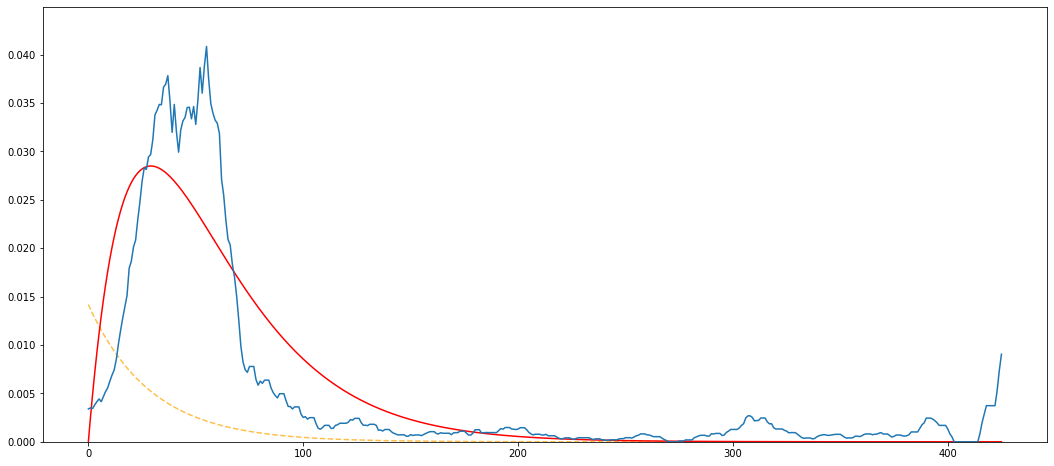

In [42]:
measureDates = getCountryDates("Australia")
    
dates, I, R, D, V = owid.LoadCountryNormal("Australia")

startDate = getIndex(dates, measureDates[-2])

dates = dates[startDate:]
I = I[startDate:]

consts = [len(I), I[0], max(I), 0]

auParamsLate = getParams(I, consts, randomIterCount=10, method = "Nelder-Mead")

fig,ax = graphParams(auParamsLate, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])